## Churn Down For What?

Definition of Churn
Why is churn important?
In recurring revenue businesses model, like Telco, customer retention is critical as the cost to retain customers is typically cheaper than the cost to gain new customers.
Defining Churn in our data.
- How much do we churn?
- What percentage of Churn is our lost revenue?
- How much potential revenue is lost to churn montly? Yearly?
-- Side note. Churn defintions table will be repeated in the comlusion and recommondation portion of the report.

### Goal:

- Discover drivers of churn using the telco_churn database.
- Use drivers to produce models that profile customers who churn.
- Provide actionable recommondatoins to limit customer churn.
- Provide the cost frame to more accuratly budget future churn mitigation initiatives. 

### Churn definition
- (Table will be repeated in the conclusion)

In [1]:
### Data Dictionary

| Feature           | Description                                                                                      |
|-------------------|--------------------------------------------------------------------------------------------------|
| add_ons           | Integer. The count of additional services a customer has subscribed to.                           |
| churn             | Bool. Indicates if a customer left the service or stayed.                                        |
| contract_type     | Categorical. Describes the duration and terms of the customer's contract (Month-to-month, One year, Two year).|
| dependents        | Bool. Indicates if the customer has any dependents.                                              |
| device_protection | Bool. Specifies if the customer has enrolled in a device protection service.                      |
| gender            | Categorical. The gender of the customer.                                                         |
| internet_type     | Categorical. Type of internet service the customer uses (DSL, Fiber optic).                       |
| monthly_charges   | Numeric. The amount charged to the customer every month.                                         |
| multiple_lines    | Categorical. Specifies if the customer has multiple phone lines or none.                         |
| online_backup     | Bool. Denotes if the customer has an online backup service.                                      |
| online_security   | Bool. Indicates if the customer has an online security service.                                  |
| paperless_billing | Bool. Specifies if the customer has chosen paperless billing.                                    |
| partner           | Bool. Indicates if the customer has a partner.                                                   |
| payment_type_id   | Categorical/Numeric. ID representing payment method (Mailed check, Bank transfer, Credit card).   |
| phone_service     | Bool. Indicates if the customer has subscribed to phone service.                                 |
| senior            | Bool. Denotes if the customer is a senior citizen.                                               |
| streaming_movies  | Bool. Indicates if the customer uses the service for streaming movies.                           |
| streaming_tv      | Bool. Indicates if the customer uses the service for streaming TV.                                |
| tech_support      | Bool. Specifies if the customer has tech support service.                                        |
| tenure            | Numeric. Number of months the customer has been with the service.                                 |
| total_charges     | Numeric. Total amount charged to the customer over their subscription period.                     |


### Imports

In [2]:
import pandas as pd
import numpy as np

import acquire as ak
import prepare
import model

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

seed = 55

### Acquire
- Data acquired from the Codeup SQL server
- Each row represents a unique customer.
- Each column represents a feature of the customer.
- Data contains 7043 rows and 53 columns before cleaning.

### Prepare /  Data snanpshot

- Removed all duplicate columns
- Renames colums to explicit name
- Dropped redundant columns in favor of their numerical or boolen counterparts.
- Dropped churn month.
- Added 'add_ons' feature which is a count of all extra features.
- 7032 rows and 21 columns after cleaning.

In [3]:
# imports all telco_churn database except for customers with 0 tenure.
## drops '11' customers
telco = ak.get_telco_churn()

# drops redundant columns in favor of their numerical or boolean counterparts. 
# drop churn month becuse all values are the same.
# rename's columns for to be more explicit or simple.
# adds a feature which is the sum of all additional services that customer has.
prepare.prep_telco(telco)
telco.head(2)

,gender,senior,partner,dependents,tenure,phone_service,multiple_lines,internet_type,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,contract_type,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,add_ons
0,Female,0,Yes,Yes,9,Yes,No,1,No,Yes,...,Yes,Yes,No,2,Yes,2,65.6,593.3,No,4
1,Male,0,No,No,9,Yes,Yes,1,No,No,...,No,No,Yes,1,No,2,59.9,542.4,No,4


In [4]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7032 non-null   object 
 1   senior             7032 non-null   int64  
 2   partner            7032 non-null   object 
 3   dependents         7032 non-null   object 
 4   tenure             7032 non-null   int64  
 5   phone_service      7032 non-null   object 
 6   multiple_lines     7032 non-null   object 
 7   internet_type      7032 non-null   int64  
 8   online_security    7032 non-null   object 
 9   online_backup      7032 non-null   object 
 10  device_protection  7032 non-null   object 
 11  tech_support       7032 non-null   object 
 12  streaming_tv       7032 non-null   object 
 13  streaming_movies   7032 non-null   object 
 14  contract_type      7032 non-null   int64  
 15  paperless_billing  7032 non-null   object 
 16  payment_type_id    7032 

### Exploration and Hypothosis testing

- Splitting Data

In [5]:
train, val, test = prepare.train_val_test(telco,'churn', seed)

In [6]:
train.head(2)

,gender,senior,partner,dependents,tenure,phone_service,multiple_lines,internet_type,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,contract_type,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,add_ons
6235,Male,0,No,Yes,39,Yes,Yes,2,No,No,...,Yes,Yes,Yes,3,No,2,100.55,3895.35,No,6
860,Male,0,Yes,Yes,52,Yes,Yes,3,No internet service,No internet service,...,No internet service,No internet service,No internet service,3,No,2,24.80,1229.10,No,3


#### 26.6% of total customers churned for the month.

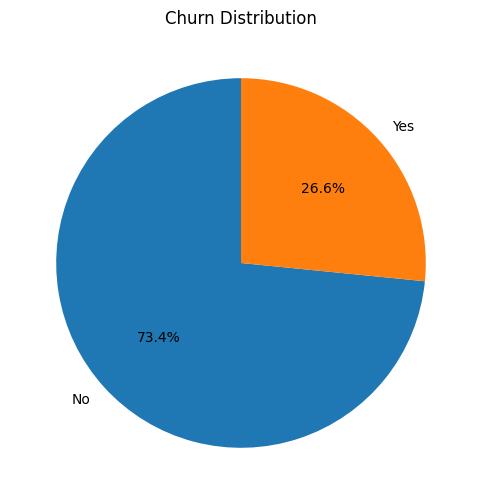

In [7]:
model.churn_pie(train)

##### Total charges vs Monthly Charges by Churn Status
- We see a lot more churn density as the monthy charge goes up.
- Less so as Total Charges go up but still noticable.

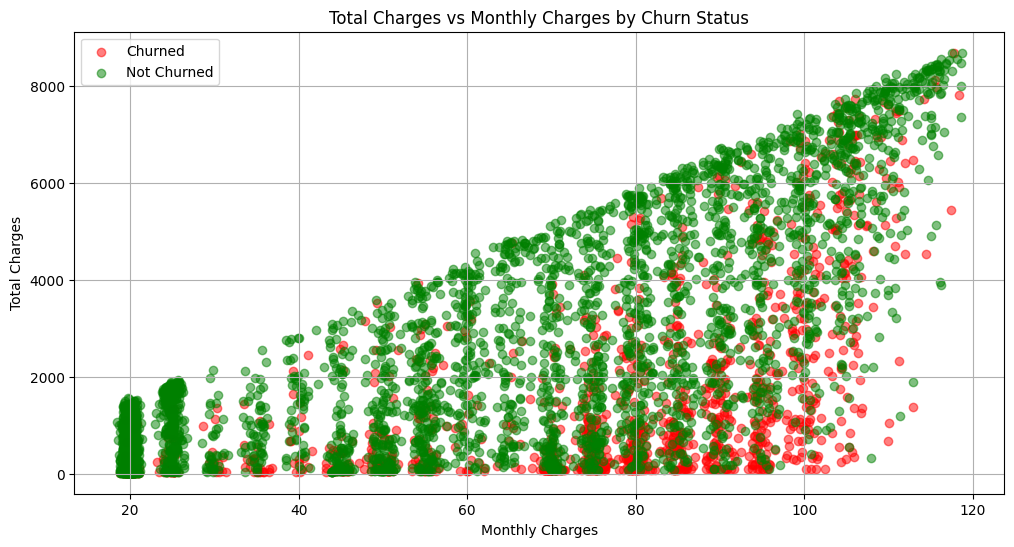

In [8]:
model.churn_scatter_plot(train)

#### Average Total Charges Over Tenure by Churn Status
- This chart cleans up the above and shows that the rates of churn are greater as teh average cost of services rise. 

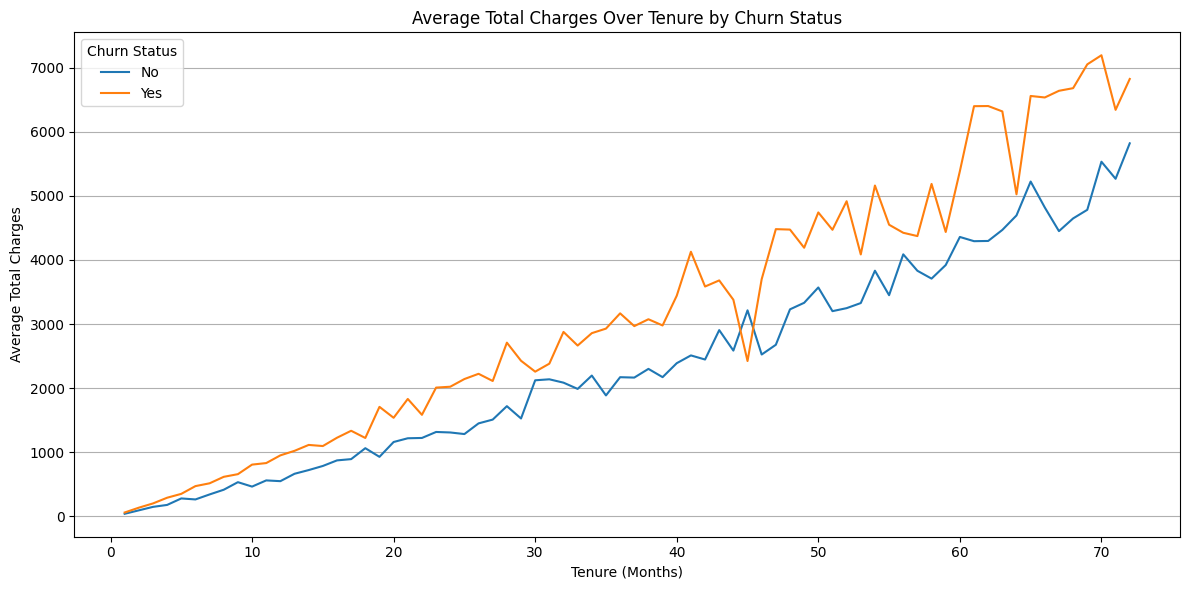

In [9]:
model.churn_line_plot(train)

#### Statistical Tests

$H_0$ tenure has NO effect on churn.

$H_a$ tenure has an effect on churn.

Mann-Whitney  test.

In [10]:
model.mann_whitney_test(train, 'tenure', 'churn')

U-statistic: 3495179.0
P-value: 9.050764064024587e-146
Reject the null hypothesis: tenure has an effect on churn.


$H_0$ total_charges has NO effect on churn.

$H_a$ total_charges has an effect on churn.

Mann-Whitney test.

In [11]:
model.mann_whitney_test(train, 'total_charges', 'churn')

U-statistic: 3067362.5
P-value: 1.706236621753235e-57
Reject the null hypothesis: total_charges has an effect on churn.


$H_0$ monthly_charges has NO effect on churn.

$H_a$ monthly_charges has an effect on churn.

Mann-Whitney test.

In [12]:
model.mann_whitney_test(train, 'monthly_charges', 'churn')

U-statistic: 1770237.0
P-value: 2.252702853411068e-41
Reject the null hypothesis: monthly_charges has an effect on churn.


$H_0$ age has NO effect on churn.

$H_a$ age has an effect on churn.

Mann-Whitney test.

In [13]:
model.mann_whitney_test(train, 'senior', 'churn')

U-statistic: 2076743.0
P-value: 3.1067208480562053e-24
Reject the null hypothesis: senior has an effect on churn.


$H_0$ gender has NO effect on churn.

$H_a$ gender has an effect on churn.

chi^2 test.

In [14]:
model.chi_squared_test(train, 'gender', 'churn')

Chi-Squared Value = 0.03792901598117664
P-value = 0.8455857454369061
Degrees of Freedom = 1
Expected Frequencies Table:
[[1794.51767574  649.48232426]
 [1819.48232426  658.51767574]]

The variables gender and churn are independent (fail to reject H_0).


(0.03792901598117664,
 0.8455857454369061,
 1,
 array([[1794.51767574,  649.48232426],
        [1819.48232426,  658.51767574]]))

$H_0$ add_ons have NO effect on churn.

$H_a$ add_ons have an effect on churn.

Mann-Whitney test.

In [15]:
model.mann_whitney_test(train, 'add_ons', 'churn')

U-statistic: 2419654.0
P-value: 0.19602702892845203
Fail to reject the null hypothesis: No significant evidence to suggest that add_ons affects churn.


### Exploration Summary

Ran a lot of statistical tests.

Gender does not have an effect on churn. Will not drop for the modeling. But can drop for future tests to improve accuracy.

The only suprise was the addons.

Add ons are correlated to monthly charge and monthly charge did affect churn. Yet addons did not affect churn. This could be an error but it completly shoots down my hypothesis that this would be one of the leading factors.
This almost certainly means there is a specific most likely very pricy add on that is driving churn.

### Modeling

Seperating 

In [16]:
x_train = train.drop(columns=['churn'])
y_train = train['churn']
x_val = val.drop(columns=['churn'])
y_val = val['churn']
x_test = test.drop(columns=['churn'])
y_test = test['churn']


Get Dummies

In [17]:
x_train = pd.get_dummies(x_train, drop_first=True)
x_val = pd.get_dummies(x_val, drop_first=True)
x_test = pd.get_dummies(x_test, drop_first=True)

#### Decision Tree

In [18]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_val_pred = clf.predict(x_val)
model.theometrics2(y_val, y_val_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 645                 130
Actual Positive                 150                 130




,Metric,Value
0,Accuracy,0.734597
1,Recall,0.464286
2,True Positive Rate,0.464286
3,False Positive Rate,0.167742
4,True Negative Rate,0.832258
5,False Negative Rate,0.535714
6,Precision,0.500000
7,F1-Score,0.481481
8,Support,280.000000


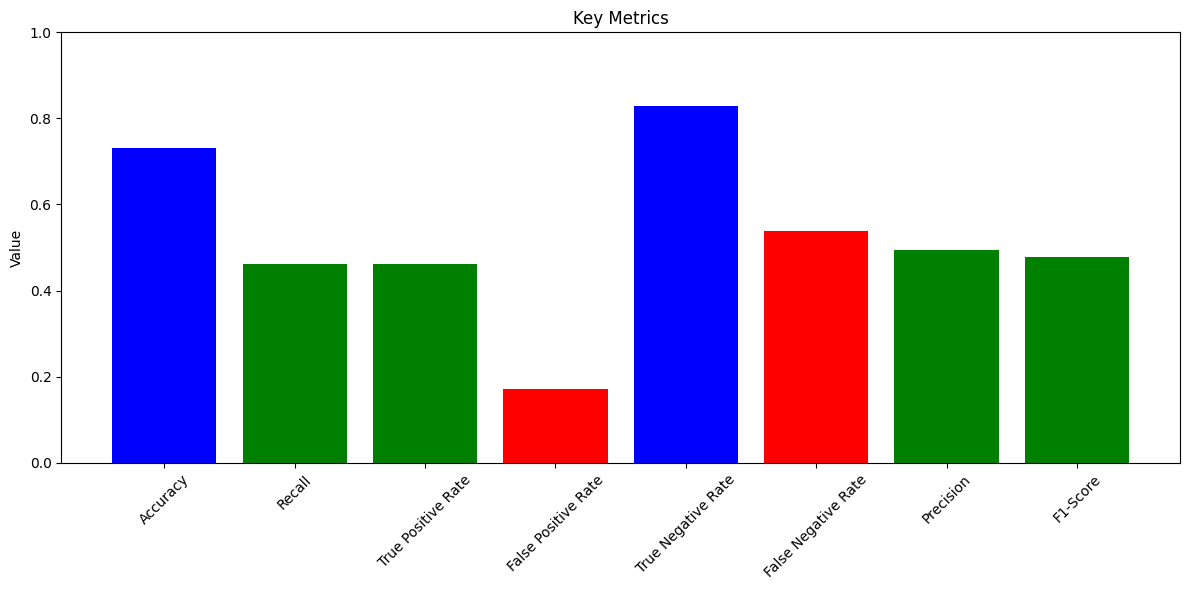

In [19]:
metrics = ['Accuracy', 'Recall', 'True Positive Rate', 'False Positive Rate',
           'True Negative Rate', 'False Negative Rate', 'Precision', 'F1-Score']
values = [0.731754, 0.460714, 0.460714, 0.170323, 0.829677, 0.539286, 0.494253, 0.476895]

plt.figure(figsize=(12, 6))
plt.bar(metrics, values, color=['blue', 'green', 'green', 'red', 'blue', 'red', 'green', 'green'])
plt.ylabel('Value')
plt.title('Key Metrics')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#### Test

In [20]:
model.theometrics2(y_test, y_val_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 589                 185
Actual Positive                 206                  75




,Metric,Value
0,Accuracy,0.629384
1,Recall,0.266904
2,True Positive Rate,0.266904
3,False Positive Rate,0.239018
4,True Negative Rate,0.760982
5,False Negative Rate,0.733096
6,Precision,0.288462
7,F1-Score,0.277264
8,Support,281.000000


#### Random Forest

In [21]:
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=3)
rf_clf.fit(x_train, y_train)
y_val_pred = rf_clf.predict(x_val)
model.theometrics2(y_val, y_val_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 747                  28
Actual Positive                 202                  78




,Metric,Value
0,Accuracy,0.781991
1,Recall,0.278571
2,True Positive Rate,0.278571
3,False Positive Rate,0.036129
4,True Negative Rate,0.963871
5,False Negative Rate,0.721429
6,Precision,0.735849
7,F1-Score,0.404145
8,Support,280.000000


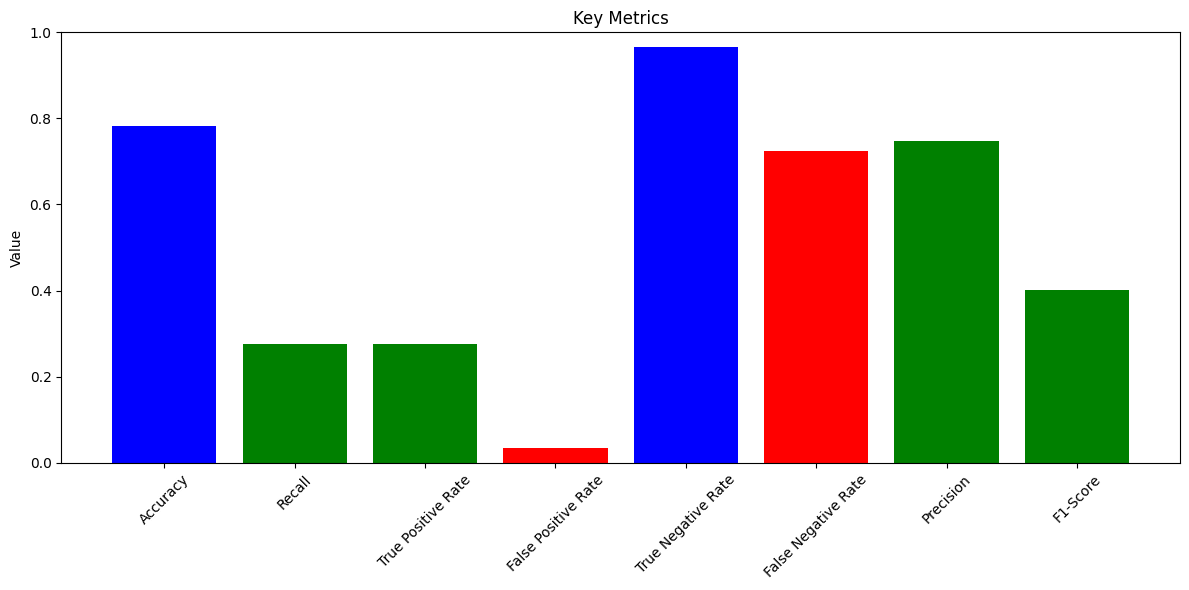

In [22]:
metrics = ['Accuracy', 'Recall', 'True Positive Rate', 'False Positive Rate',
           'True Negative Rate', 'False Negative Rate', 'Precision', 'F1-Score']
values = [0.782938, 0.275000, 0.275000, 0.033548, 0.966452, 0.725000, 0.747573, 0.402089]

plt.figure(figsize=(12, 6))
plt.bar(metrics, values, color=['blue', 'green', 'green', 'red', 'blue', 'red', 'green', 'green'])
plt.ylabel('Value')
plt.title('Key Metrics')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#### Test

In [23]:
model.theometrics2(y_test, y_val_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 697                  77
Actual Positive                 252                  29




,Metric,Value
0,Accuracy,0.688152
1,Recall,0.103203
2,True Positive Rate,0.103203
3,False Positive Rate,0.099483
4,True Negative Rate,0.900517
5,False Negative Rate,0.896797
6,Precision,0.273585
7,F1-Score,0.149871
8,Support,281.000000


#### Logistic Regression 

In [24]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_val_pred = logreg.predict(x_val)
model.theometrics2(y_val, y_val_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 692                  83
Actual Positive                 134                 146




,Metric,Value
0,Accuracy,0.794313
1,Recall,0.521429
2,True Positive Rate,0.521429
3,False Positive Rate,0.107097
4,True Negative Rate,0.892903
5,False Negative Rate,0.478571
6,Precision,0.637555
7,F1-Score,0.573674
8,Support,280.000000


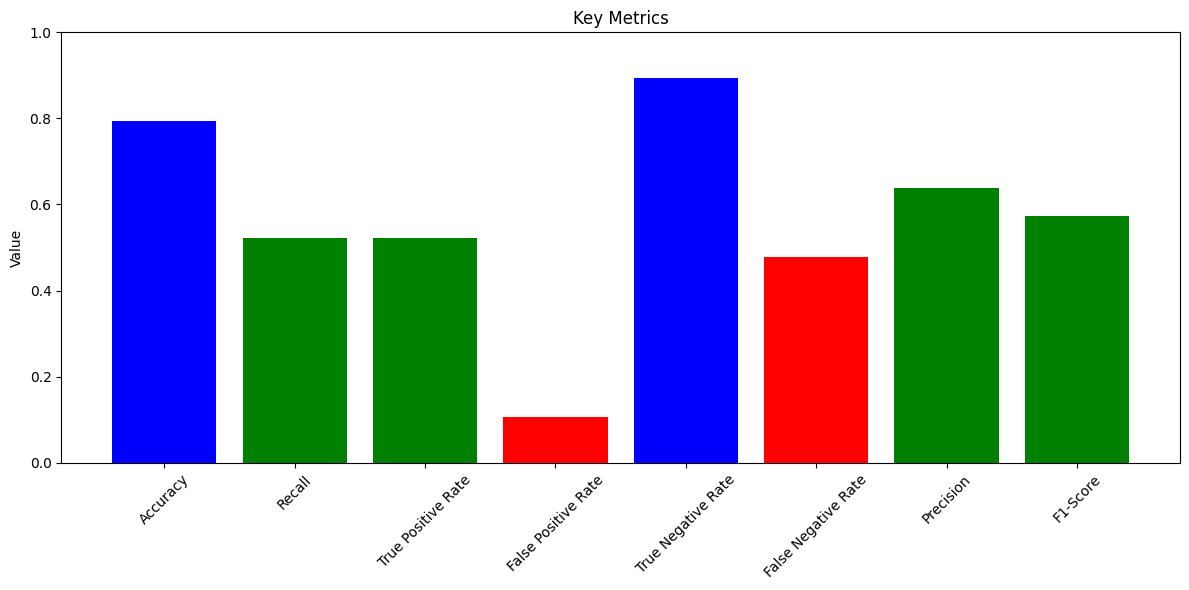

In [25]:
metrics = ['Accuracy', 'Recall', 'True Positive Rate', 'False Positive Rate',
           'True Negative Rate', 'False Negative Rate', 'Precision', 'F1-Score']
values = [0.794313, 0.521429, 0.521429, 0.107097, 0.892903, 0.478571, 0.637555, 0.573674]

plt.figure(figsize=(12, 6))
plt.bar(metrics, values, color=['blue', 'green', 'green', 'red', 'blue', 'red', 'green', 'green'])
plt.ylabel('Value')
plt.title('Key Metrics')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#### Test

In [28]:
model.theometrics2(y_test, y_val_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 608                 166
Actual Positive                 218                  63




,Metric,Value
0,Accuracy,0.636019
1,Recall,0.224199
2,True Positive Rate,0.224199
3,False Positive Rate,0.214470
4,True Negative Rate,0.785530
5,False Negative Rate,0.775801
6,Precision,0.275109
7,F1-Score,0.247059
8,Support,281.000000


#### Model assesement

### Comparing Models

In [ ]:
Logistic regression had the best model.

### Model Summary

### Conclusion

#### Exploration

#### Modeling

#### Churn Definition 

### Insights

### Business Recommendations

#### Churn Definition 

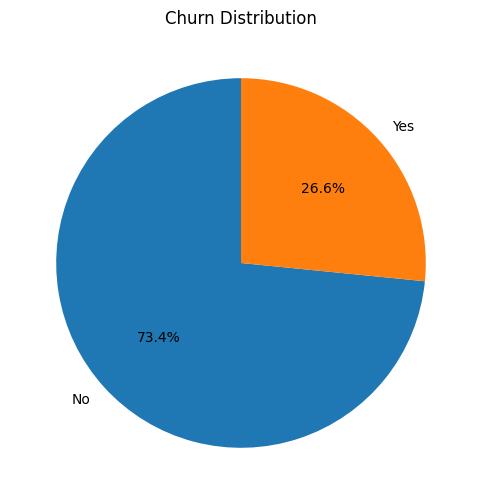

In [27]:
model.churn_pie(train)

### Data Science next steps

Next step would be to tun a 